In [1]:
import json
import logging
from pathlib import Path
import random
import tarfile
import tempfile
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pandas_path  # Path style access for pandas
from tqdm import tqdm

import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, get_scheduler
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import os

import torch                    
import torchvision
import fasttext

In [2]:
path = os.getcwd()
df = pd.read_json(path + '/MMHS150K/MMHS150K_GT.json', orient='index')
df.sample(5)

,img_url,labels,tweet_url,tweet_text,labels_str
2005-04-29 06:09:30.799222784,http://pbs.twimg.com/media/D3hnvHBW0AA8GZk.jpg,"[0, 0, 1]",https://twitter.com/user/status/11147549707992...,@KodakBlack1k Yea you a goofy nigga for that ...,"[NotHate, NotHate, Racist]"
2005-03-01 01:19:39.305705474,http://pbs.twimg.com/media/D2Y7rY8XcAE901G.jpg,"[0, 1, 0]",https://twitter.com/user/status/11096399793057...,@guycalledkai Count your days nigga😴 https://t...,"[NotHate, Racist, NotHate]"
2003-09-07 07:43:10.573666304,http://pbs.twimg.com/media/DsBApCRXQAE46jB.jpg,"[5, 1, 0]",https://twitter.com/user/status/10629205905736...,@IvankaTrump @JTIP_State White trash grifters!...,"[OtherHate, Racist, NotHate]"
2005-02-15 06:51:36.898961409,http://pbs.twimg.com/tweet_video_thumb/D2IBqrx...,"[0, 0, 0]",https://twitter.com/user/status/11084502968989...,@EditinKing Muscle Head ass nigga https://t.co...,"[NotHate, NotHate, NotHate]"
2005-04-13 22:12:26.157174789,http://pbs.twimg.com/media/D3Oy_4cX4AEwXKB.jpg,"[0, 1, 0]",https://twitter.com/user/status/11134303461571...,This nigga Kaneki was an OG no cap https://t.c...,"[NotHate, Racist, NotHate]"


In [3]:
# labels: 0 - NotHate, 1 - Racist, 2 - Sexist, 3 - Homophobe, 4 - Religion, 5 - OtherHate

# extract tweet id from tweet url
df['tweet_id'] = df['tweet_url'].apply(lambda x: x.split('/')[-1])

# create a new column for each label
df['is_hateful'] = df['labels'].apply(lambda x: bool(x))
# create a new column for each label
df['is_racist'] = df['labels'].apply(lambda x: 1 in x)
df['is_sexist'] = df['labels'].apply(lambda x: 2 in x)
df['is_homophobe'] = df['labels'].apply(lambda x: 3 in x)
df['is_religion'] = df['labels'].apply(lambda x: 4 in x)
df['is_other_hate'] = df['labels'].apply(lambda x: 5 in x)

# remove the labels column
df = df.drop(columns=['labels'])
# remove the labels_str column
df = df.drop(columns=['labels_str'])

# reset index => remove date and get a new index
df = df.reset_index(drop=True)

In [4]:
df.head()

,img_url,tweet_url,tweet_text,tweet_id,is_hateful,is_racist,is_sexist,is_homophobe,is_religion,is_other_hate
0,http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...,https://twitter.com/user/status/11146793537140...,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,1114679353714016256,True,True,False,True,True,False
1,http://pbs.twimg.com/ext_tw_video_thumb/106301...,https://twitter.com/user/status/10630200488166...,My horses are retarded https://t.co/HYhqc6d5WN,1063020048816660480,True,False,False,False,False,True
2,http://pbs.twimg.com/media/D2OzhzHUwAADQjd.jpg,https://twitter.com/user/status/11089273680753...,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,1108927368075374593,True,False,False,False,False,False
3,http://pbs.twimg.com/ext_tw_video_thumb/111401...,https://twitter.com/user/status/11145585346356...,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,1114558534635618305,True,True,False,False,False,False
4,http://pbs.twimg.com/media/Dl30pGIU8AAVGxO.jpg,https://twitter.com/user/status/10352524802155...,“EVERYbody calling you Nigger now!” https://t....,1035252480215592966,True,True,False,False,False,False


In [5]:
## training parameters to be used for all models ##
num_train_epochs = 5
batch_size = 16
learning_rate = 1.0e-5
weight_decay = 0.01
warmup_steps = 0
max_seq_length = 64

# Hateful / pas hateful

premier essai: binary classification

In [6]:
df_bin = df
# remove is_racist, is_sexist, is_homophobe, is_religion, is_other_hate columns
df_bin = df_bin.drop(columns=['is_racist', 'is_sexist', 'is_homophobe', 'is_religion', 'is_other_hate'])
df_bin.head()

,img_url,tweet_url,tweet_text,tweet_id,is_hateful
0,http://pbs.twimg.com/tweet_video_thumb/D3gi9MH...,https://twitter.com/user/status/11146793537140...,@FriskDontMiss Nigga https://t.co/cAsaLWEpue,1114679353714016256,True
1,http://pbs.twimg.com/ext_tw_video_thumb/106301...,https://twitter.com/user/status/10630200488166...,My horses are retarded https://t.co/HYhqc6d5WN,1063020048816660480,True
2,http://pbs.twimg.com/media/D2OzhzHUwAADQjd.jpg,https://twitter.com/user/status/11089273680753...,“NIGGA ON MA MOMMA YOUNGBOY BE SPITTING REAL S...,1108927368075374593,True
3,http://pbs.twimg.com/ext_tw_video_thumb/111401...,https://twitter.com/user/status/11145585346356...,RT xxSuGVNGxx: I ran into this HOLY NIGGA TODA...,1114558534635618305,True
4,http://pbs.twimg.com/media/Dl30pGIU8AAVGxO.jpg,https://twitter.com/user/status/10352524802155...,“EVERYbody calling you Nigger now!” https://t....,1035252480215592966,True


In [46]:
df_bin_sample = df_bin.sample(1000, random_state=42).reset_index(drop=True)
df_bin_sample.head()

,img_url,tweet_url,tweet_text,tweet_id,is_hateful
0,http://pbs.twimg.com/media/D2c809SWkAMaFD-.jpg,https://twitter.com/user/status/11099227256430...,I’m that mf nigga✨ https://t.co/T2QE1qaHFX,1109922725643067392,True
1,http://pbs.twimg.com/media/D1Zi2FcWoAAuWiE.jpg,https://twitter.com/user/status/11051794566526...,He's just a gay cunt. Such a fuckin gay cunt. ...,1105179456652656640,True
2,http://pbs.twimg.com/media/DqTJ-_UWoAAJbeI.jpg,https://twitter.com/user/status/10551903113523...,@politico Also spread by SCOTUS justice Thomas...,1055190311352352768,True
3,http://pbs.twimg.com/tweet_video_thumb/D2RKpac...,https://twitter.com/user/status/11090934950867...,@DFrancis__ Lmaoooooo nigga so cap I bought em...,1109093495086768131,True
4,http://pbs.twimg.com/tweet_video_thumb/D2KmIER...,https://twitter.com/user/status/11086311234652...,@uncleswaggy Nigga got up like https://t.co/VC...,1108631123465252864,True


In [47]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [48]:
class HateSpeechDataset(Dataset):
    def __init__(self, df, tokenizer, max_seq_length):
        self.df = df
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.loc[idx, 'tweet_text']
        label = self.df.loc[idx, 'is_hateful']

        inputs = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [49]:
# create dataset
label_to_id = {False: 0, True: 1}
dataset = HateSpeechDataset(df_bin_sample, bert_tokenizer, max_seq_length)

In [50]:
# split dataset between train, validation and test
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [51]:
class HateSpeechClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super(HateSpeechClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state_cls = outputs.last_hidden_state[:, 0, :]
        logits = self.classifier(last_hidden_state_cls)
        return logits

In [52]:
# training

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = HateSpeechClassifier('bert-base-uncased', num_labels=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_train_epochs * len(train_dataloader)
)

def train(model, dataloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            total_correct += torch.sum(preds == labels).item()

    return total_loss / len(dataloader), total_correct / len(dataloader.dataset)

best_val_loss = float('inf')
for epoch in range(num_train_epochs):
    train_loss = train(model, train_dataloader, criterion, optimizer, scheduler, device)
    val_loss, val_acc = evaluate(model, val_dataloader, criterion, device)
    print(f'Epoch {epoch + 1}/{num_train_epochs}')
    print(f'Training Loss: {train_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    print(f'Validation Accuracy: {val_acc:.4f}')
    print()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'model.pt')
        
        
# testing
model.load_state_dict(torch.load('model.pt'))
test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Training:   0%|          | 0/50 [00:00<?, ?it/s]/var/folders/07/9l9kqd013xjdlz8_0b2__8xr0000gq/T/ipykernel_63143/1665288817.py:26: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  'labels': torch.tensor(label, dtype=torch.long)
Evaluating: 100%|██████████| 7/7 [00:01<00:00,  6.55it/s]


Epoch 1/5
Training Loss: 0.0604
Validation Loss: 0.0006
Validation Accuracy: 1.0000



Evaluating: 100%|██████████| 7/7 [00:00<00:00, 14.39it/s]


Epoch 2/5
Training Loss: 0.0008
Validation Loss: 0.0004
Validation Accuracy: 1.0000



Evaluating: 100%|██████████| 7/7 [00:00<00:00, 14.19it/s]


Epoch 3/5
Training Loss: 0.0006
Validation Loss: 0.0003
Validation Accuracy: 1.0000



Evaluating: 100%|██████████| 7/7 [00:00<00:00, 14.38it/s]


Epoch 4/5
Training Loss: 0.0005
Validation Loss: 0.0002
Validation Accuracy: 1.0000



Evaluating: 100%|██████████| 7/7 [00:00<00:00, 14.47it/s]


Epoch 5/5
Training Loss: 0.0005
Validation Loss: 0.0002
Validation Accuracy: 1.0000



Evaluating: 100%|██████████| 7/7 [00:00<00:00, 13.76it/s]

Test Loss: 0.0002
Test Accuracy: 1.0000


# VisualBert

In [54]:
from transformers import AutoImageProcessor, ResNetForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

image = torch.rand(1, 3, 800, 800)
inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


nematode, nematode worm, roundworm


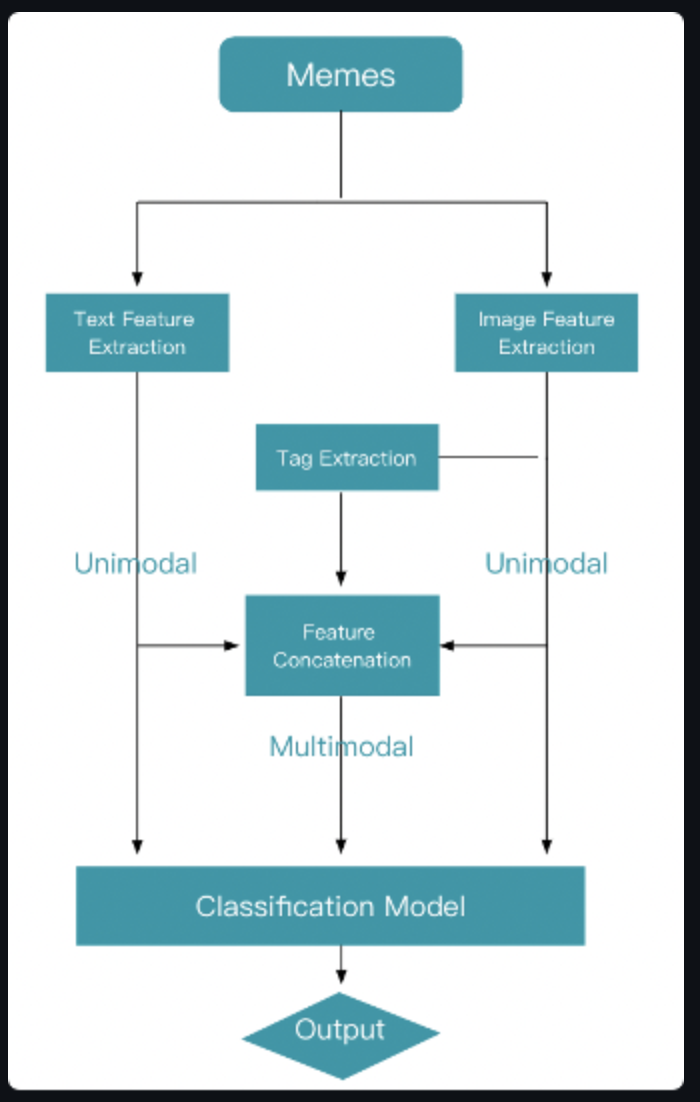